In [1]:
!pip install krippendorff
!pip install boto3
!pip install pyirr

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.3 MB/s eta 0:00:00


In [2]:
import sqlite3
import time
import datetime
import random
import pandas as pd
from ast import literal_eval
import json
import numpy as np
import krippendorff
import boto3
import io
import csv
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from statsmodels.stats.inter_rater import fleiss_kappa
import krippendorff

import nltk
from nltk import agreement

from nltk import ngrams
from sklearn.metrics.pairwise import cosine_similarity


from pyirr import read_data, kappam_fleiss
from collections import Counter

import ast

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Connectie maken en Prodigy output uit database halen

## Batch 1

In [3]:
conn = sqlite3.connect('batch1.db')

# Get a cursor object
cursor = conn.cursor()

# Query the SQLite database for a list of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()

# Read data from a table in the database into a pandas DataFrame
df = pd.read_sql_query('SELECT * FROM example', conn)

# Close the cursor and the connection to the database
cursor.close()
conn.close()

In [4]:
df_batch1 = pd.DataFrame()

df_batch1['prodigy_output'] = df['content']

df_batch1['decoded_output'] = df_batch1['prodigy_output'].apply(lambda x: literal_eval(x.decode('utf8')))

df_batch1['decoded_output'][0]['text']

'Via de sollicitatie van WERKMAATSCHAPPIJ heb ik snel een nieuwe baan gevonden. Alleen heb ik voor zover ik weet nog geen contract en is er onduidelijkheid over de uren. Maar dat valt allemaal op te lossen en ik vind het prettig dat er heel snel geschakeld kan worden.'

### Retrieve relevant output from Prodigy output and append to df

In [5]:
##retrieve text
def retrieve_var(var_name: str, col_name: str):
    get_var = lambda row: row['decoded_output'][var_name]
    df_batch1[col_name] = df_batch1.apply(get_var, axis= 1)
            

In [6]:
retrieve_var('datum_resultaat', 'datum_resultaat')
retrieve_var('text', 'text')
retrieve_var('_session_id', 'session_id')
retrieve_var('answer', 'answer')
retrieve_var('accept', 'accept')

### sort accept column + ignore health session

In [7]:
df_batch1['accept'] = df_batch1['accept'].apply(lambda x: sorted(x))
df_batch1.shape

df_batch1 = df_batch1[df_batch1['session_id'] != 'batch1-health']
df_batch1.shape

(1491, 7)

In [8]:
#add missing annotations
counts = df_batch1['text'].value_counts()
df_batch1['count'] = df_batch1.groupby('text')['text'].transform('count')
df_add = df_batch1[df_batch1['text'].isin(counts[counts < 3].index)]
df_add = df_add.drop_duplicates(subset='text', keep='first')
df_add['session_id'] = 'manual'
df_batch1_new = pd.concat([df_batch1, df_add], ignore_index=True)

df_batch1_new = df_batch1_new.drop('count', axis=1)
df_batch1_new['answer'] = df_batch1_new['answer'].fillna(value='accept')

#remove non unicode chars and write to csv
df_batch1_new['text'] = df_batch1_new['text'].replace({r'[^\x00-\x7F]+':''}, regex=True)
df_batch1_new.to_csv('data/preprocessed_batch1.csv', sep=';', encoding='utf8')

## Batch 2

In [9]:
conn = sqlite3.connect('batch2.db')

# Get a cursor object
cursor = conn.cursor()

# Query the SQLite database for a list of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()

# Read data from a table in the database into a pandas DataFrame
df = pd.read_sql_query('SELECT * FROM example', conn)

# Close the cursor and the connection to the database
cursor.close()
conn.close()

In [10]:
df_batch2 = pd.DataFrame()

df_batch2['prodigy_output'] = df['content']

df_batch2['decoded_output'] = df_batch2['prodigy_output'].apply(lambda x: literal_eval(x.decode('utf8')))

df_batch2['decoded_output'][0]['text']

'Telefonische contact  was goed     daarna  niets meer vangehoord  terwijl ik de volgende dag  iets zou horen  nu  2 dagen verder'

In [11]:
##retrieve text
def retrieve_var(var_name: str, col_name: str):
    get_var = lambda row: row['decoded_output'][var_name]
    df_batch2[col_name] = df_batch2.apply(get_var, axis= 1)

In [12]:
retrieve_var('datum_resultaat', 'datum_resultaat')
retrieve_var('text', 'text')
retrieve_var('_session_id', 'session_id')
retrieve_var('answer', 'answer')
retrieve_var('accept', 'accept')

In [13]:
df_batch2['accept'] = df_batch2['accept'].apply(lambda x: sorted(x))
df_batch2.shape

#df_batch1 = df_batch1[df_batch1['session_id'] != 'batch1-health']
#df_batch1.shape

(1998, 7)

In [14]:
#add missing annotations
counts = df_batch2['text'].value_counts()
df_batch2['count'] = df_batch2.groupby('text')['text'].transform('count')
df_add = df_batch2[df_batch2['text'].isin(counts[counts < 4].index)]
df_add = df_add.drop_duplicates(subset='text', keep='first')
df_add['session_id'] = 'manual'
df_batch2_new = pd.concat([df_batch2, df_add], ignore_index=True)

df_batch2_new = df_batch2_new.drop('count', axis=1)
df_batch2_new['answer'] = df_batch2_new['answer'].fillna(value='accept')

#remove non unicode chars and write to csv
df_batch2_new['text'] = df_batch2_new['text'].replace({r'[^\x00-\x7F]+':''}, regex=True)
df_batch2_new.to_csv('data/preprocessed_batch2.csv', sep=';', encoding='utf8')

## Batch 3

In [15]:
conn = sqlite3.connect('batch3.db')

# Get a cursor object
cursor = conn.cursor()

# Query the SQLite database for a list of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()

# Read data from a table in the database into a pandas DataFrame
df = pd.read_sql_query('SELECT * FROM example', conn)

# Close the cursor and the connection to the database
cursor.close()
conn.close()

In [16]:
df_batch3 = pd.DataFrame()

df_batch3['prodigy_output'] = df['content']

df_batch3['decoded_output'] = df_batch3['prodigy_output'].apply(lambda x: literal_eval(x.decode('utf8')))

df_batch3['decoded_output'][0]['text']

'Bij vak inhoudelijke trainingen die op future friday worden gegeven, zou het raadzaam zijn om rekening te houden met aantal trainees. Tot nu toe 3x geprobeerd in te schrijven en altijd vol...'

In [17]:
##retrieve text
def retrieve_var(var_name: str, col_name: str):
    get_var = lambda row: row['decoded_output'][var_name]
    df_batch3[col_name] = df_batch3.apply(get_var, axis= 1)

In [18]:
retrieve_var('datum_resultaat', 'datum_resultaat')
retrieve_var('text', 'text')
retrieve_var('_session_id', 'session_id')
retrieve_var('answer', 'answer')
retrieve_var('accept', 'accept')

In [19]:
df_batch3['accept'] = df_batch3['accept'].apply(lambda x: sorted(x))
df_batch3.shape

(1993, 7)

In [20]:
#add missing annotations
counts = df_batch3['text'].value_counts()
df_batch3['count'] = df_batch3.groupby('text')['text'].transform('count')
df_add = df_batch3[df_batch3['text'].isin(counts[counts < 4].index)]
df_add = df_add.drop_duplicates(subset='text', keep='first')
df_add['session_id'] = 'manual'
df_batch3_new = pd.concat([df_batch3, df_add], ignore_index=True)

df_batch3_new = df_batch3_new.drop('count', axis=1)
df_batch3_new['answer'] = df_batch3_new['answer'].fillna(value='accept')

#remove non unicode chars and write to csv
df_batch3_new['text'] = df_batch3_new['text'].replace({r'[^\x00-\x7F]+':''}, regex=True)
df_batch3_new.to_csv('data/preprocessed_batch3.csv', sep=';', encoding='utf8')

# Annotation evaluation

In [21]:
batch1 = pd.read_csv('data/preprocessed_batch1.csv', sep=';')
batch2 = pd.read_csv('data/preprocessed_batch2.csv', sep=';')
batch3 = pd.read_csv('data/preprocessed_batch3.csv', sep=';')

## batch 1

In [22]:
pivoted_df1 = batch1.groupby(['text', 'session_id'])['accept'].first().unstack().reset_index()

# Create a subset of the DataFrame with relevant columns and replacement column
df_subset1 = pivoted_df1[['text', 'batch1-p1dJf8bNcR','batch1-q1kEz5xVnW','batch1-s1gHt0uLrM', 'manual']].copy()

# Replace NaN values in each column with values from the 'Replacement' column
for col in df_subset1.columns:
    df_subset1[col].fillna(df_subset1['manual'], inplace=True)
    
df1_withtext = df_subset1.drop(['manual'], axis=1)
df_subset1 = df_subset1.drop(['manual', 'text'], axis=1)
df_subset1.shape

(500, 3)

In [23]:
# Convert non-numeric annotations to integer labels
unique_labels = set()
for col in df_subset1.columns:
    if not pd.api.types.is_numeric_dtype(df_subset1[col]):
        unique_labels.update(df_subset1[col].unique())

label_dict = {label: i for i, label in enumerate(unique_labels)}
for col in df_subset1.columns:
    if not pd.api.types.is_numeric_dtype(df_subset1[col]):
        df_subset1[col] = df_subset1[col].apply(lambda x: label_dict[x])

# Convert annotations to a numpy array
annotations = df_subset1.to_numpy()

# Calculate Krippendorff's alpha
alpha = krippendorff.alpha(reliability_data=annotations, level_of_measurement='nominal')

print('Krippendorff\'s alpha:', alpha, '\n')


kappa = kappam_fleiss(annotations, detail=True)

print(f"Fleiss' Kappa between the three columns: {kappa}")

# Create a mask for each condition
mask_all_same = (df1_withtext['batch1-p1dJf8bNcR'] == df1_withtext['batch1-q1kEz5xVnW']) & (df1_withtext['batch1-q1kEz5xVnW'] == df1_withtext['batch1-s1gHt0uLrM'])
mask_two_same = ((df1_withtext['batch1-p1dJf8bNcR'] == df1_withtext['batch1-q1kEz5xVnW']) | (df1_withtext['batch1-p1dJf8bNcR'] == df1_withtext['batch1-s1gHt0uLrM']) | (df1_withtext['batch1-q1kEz5xVnW'] == df1_withtext['batch1-s1gHt0uLrM'])) & (~mask_all_same)
mask_all_different = ~(mask_all_same | mask_two_same)

# Create the dataframes based on the masks
df_all_same = df1_withtext[mask_all_same].copy()
df_two_same = df1_withtext[mask_two_same].copy()
df_all_different = df1_withtext[mask_all_different].copy()

print(f"In total, {df_all_same.shape[0]} sentences have a 100% agreement, \n{df_two_same.shape[0]} have agreement between 2/3 annotators\nand {df_all_different.shape[0]} have no agreement and thus need reannotation.")

Krippendorff's alpha: -9.212111230860742e-05 

Fleiss' Kappa between the three columns: ==================================================
            Fleiss` Kappa for m Raters            
Subjects = 500
  Raters = 3
   Kappa = 0.596

       z = 65.698
 p-value = 0.000

    Kappa       z  p.value
0   0.451  17.448    0.000
1   0.197   7.642    0.000
2   0.329  12.754    0.000
3  -0.001  -0.026    0.979
4   0.673  26.065    0.000
5  -0.001  -0.026    0.979
6   1.000  38.730    0.000
7   0.368  14.263    0.000
8   0.246   9.527    0.000
9   0.520  20.149    0.000
10  0.640  24.801    0.000
11 -0.001  -0.026    0.979
12  0.351  13.598    0.000
13 -0.001  -0.026    0.979
14  0.639  24.767    0.000
15  0.500  19.349    0.000
16 -0.001  -0.026    0.979
17  0.498  19.287    0.000
18  0.331  12.806    0.000
19  0.497  19.261    0.000
20  0.499  19.339    0.000
21  0.828  32.064    0.000
22  0.749  29.021    0.000
23 -0.001  -0.026    0.979
24 -0.001  -0.026    0.979
25 -0.001  -0.026    0.979

In [24]:
def find_annotations(row):
    #print(row[1])
    #print(row[2])
    #print(row[3])
    list_once = list()
    list_twice = list()
    if row[1] == row[2]:
        list_twice.append(row[1])
        list_once.append(row[3])
    if row[1] == row[3]:
        list_twice.append(row[1])
        list_once.append(row[2])
    if row[2] == row[3]:
        list_twice.append(row[2])
        list_once.append(row[1])
    #print(list_once)
    #print(list_twice)
    return pd.Series([ast.literal_eval(list_once[0]), ast.literal_eval(list_twice[0])], index=['once', 'twice']) 

### prepare final dataset for batch 1

In [25]:
# Find the common annotation for each row
df_two_same['common_annotation'] = df_two_same.apply(
    lambda row: row['batch1-p1dJf8bNcR'] if row['batch1-p1dJf8bNcR'] == row['batch1-q1kEz5xVnW'] or row['batch1-p1dJf8bNcR'] == row['batch1-s1gHt0uLrM'] else row['batch1-q1kEz5xVnW'],
    axis=1
)

new_df = pd.DataFrame()
# Apply the function to the column and create new columns
new_df = df_two_same.apply(find_annotations, axis=1)
new_df['occurs_in_twice'] = new_df.apply(lambda row: any(value in row['twice'] for value in row['once']), axis=1)
print(Counter(new_df['occurs_in_twice']))

# Drop the annotator columns
df_two_same = df_two_same.drop(columns=['batch1-p1dJf8bNcR','batch1-q1kEz5xVnW','batch1-s1gHt0uLrM'])

# Drop duplicate sentences and keep the common annotation
df_two_same = df_two_same.drop_duplicates(subset=['text'], keep='first')

# Drop duplicate sentences and keep the first annotator's annotation
df_all_same = df_all_same[['text', 'batch1-p1dJf8bNcR']].drop_duplicates(subset=['text'], keep='first')

# Rename the 'annotator1' column to 'common_annotation'
df_all_same = df_all_same.rename(columns={'batch1-p1dJf8bNcR': 'common_annotation'})
df_all_same = df_all_same[['text', 'common_annotation']]

Counter({False: 116, True: 82})


In [26]:
Counter(new_df['occurs_in_twice'])

Counter({False: 116, True: 82})

In [27]:
82/116

0.7068965517241379

In [28]:
#store df's per batch
df1all_same = df_all_same.copy()
df1two_same =df_two_same.copy()
df1all_different = df_all_different.copy()

#combine datasets with agreement
batch1_dataset = pd.concat([df_all_same, df_two_same])
batch1_dataset

#write dataset without agreement to .csv for re-annotation
df_all_different['common_annotation'] = ''
#df_all_different.to_csv("data/batch1_reannotation.csv", sep=";")

## batch2

In [29]:
pivoted_df2 = batch2.groupby(['text', 'session_id'])['accept'].first().unstack().reset_index()

# Create a subset of the DataFrame with relevant columns and replacement column
#df_subset2 = pivoted_df2[['text', 'batch2-v2gJkDpZ5M', 'batch2-x2wPqT7rS4','batch2-y2nLcHfB8X', 'manual']].copy()
df_subset2 = pivoted_df2[['text', 'batch2-health', 'batch2-v2gJkDpZ5M','batch2-y2nLcHfB8X', 'manual']].copy()

# Replace NaN values in each column with values from the 'Replacement' column
for col in df_subset2.columns:
    df_subset2[col].fillna(df_subset2['manual'], inplace=True)
    
df2_withtext = df_subset2.drop(['manual'], axis=1)
df_subset2 = df_subset2.drop(['manual', 'text'], axis=1)
df_subset2.shape

(500, 3)

In [30]:
pivoted_df2.columns

Index(['text', 'batch2-health', 'batch2-v2gJkDpZ5M', 'batch2-x2wPqT7rS4',
       'batch2-y2nLcHfB8X', 'manual'],
      dtype='object', name='session_id')

In [31]:
# Convert non-numeric annotations to integer labels
unique_labels = set()
for col in df_subset2.columns:
    if not pd.api.types.is_numeric_dtype(df_subset2[col]):
        unique_labels.update(df_subset2[col].unique())

label_dict = {label: i for i, label in enumerate(unique_labels)}
for col in df_subset2.columns:
    if not pd.api.types.is_numeric_dtype(df_subset2[col]):
        df_subset2[col] = df_subset2[col].apply(lambda x: label_dict[x])

# Convert annotations to a numpy array
annotations = df_subset2.to_numpy()

# Calculate Krippendorff's alpha
alpha = krippendorff.alpha(reliability_data=annotations, level_of_measurement='nominal')

print('Krippendorff\'s alpha:', alpha, '\n')


kappa = kappam_fleiss(annotations, detail=True)

print(f"Fleiss' Kappa between the three columns: {kappa}")

# Create a mask for each condition
mask_all_same = (df2_withtext['batch2-v2gJkDpZ5M'] == df2_withtext['batch2-health']) & (df2_withtext['batch2-health'] == df2_withtext['batch2-y2nLcHfB8X'])
mask_two_same = ((df2_withtext['batch2-v2gJkDpZ5M'] == df2_withtext['batch2-health']) | (df2_withtext['batch2-v2gJkDpZ5M'] == df2_withtext['batch2-y2nLcHfB8X']) | (df2_withtext['batch2-health'] == df2_withtext['batch2-y2nLcHfB8X'])) & (~mask_all_same)
mask_all_different = ~(mask_all_same | mask_two_same)

# Create the dataframes based on the masks
df_all_same = df2_withtext[mask_all_same].copy()
df_two_same = df2_withtext[mask_two_same].copy()
df_all_different = df2_withtext[mask_all_different].copy()

print(f"In total, {df_all_same.shape[0]} sentences have a 100% agreement, \n{df_two_same.shape[0]} have agreement between 2/3 annotators\nand {df_all_different.shape[0]} have no agreement and thus need reannotation.")


Krippendorff's alpha: 0.002024011349653687 

Fleiss' Kappa between the three columns: ==================================================
            Fleiss` Kappa for m Raters            
Subjects = 500
  Raters = 3
   Kappa = 0.467

       z = 55.623
 p-value = 0.000

    Kappa       z  p.value
0  -0.003  -0.104    0.918
1  -0.001  -0.026    0.979
2  -0.001  -0.026    0.979
3  -0.001  -0.052    0.959
4   0.465  17.991    0.000
..    ...     ...      ...
72  0.462  17.891    0.000
73 -0.003  -0.130    0.897
74 -0.003  -0.130    0.897
75 -0.002  -0.078    0.938
76 -0.001  -0.026    0.979

[77 rows x 3 columns]

In total, 193 sentences have a 100% agreement, 
210 have agreement between 2/3 annotators
and 97 have no agreement and thus need reannotation.


### prepare final dataset for batch 2

In [32]:
# Find the common annotation for each row
df_two_same['common_annotation'] = df_two_same.apply(
    lambda row: row['batch2-v2gJkDpZ5M'] if row['batch2-v2gJkDpZ5M'] == row['batch2-health'] or row['batch2-v2gJkDpZ5M'] == row['batch2-y2nLcHfB8X'] else row['batch2-health'],
    axis=1
)

new_df = pd.DataFrame()
# Apply the function to the column and create new columns
new_df = df_two_same.apply(find_annotations, axis=1)
new_df['occurs_in_twice'] = new_df.apply(lambda row: any(value in row['twice'] for value in row['once']), axis=1)
print(Counter(new_df['occurs_in_twice']))

# Drop the annotator columns
df_two_same = df_two_same.drop(columns=['batch2-v2gJkDpZ5M','batch2-health','batch2-y2nLcHfB8X'])

# Drop duplicate sentences and keep the common annotation
df_two_same = df_two_same.drop_duplicates(subset=['text'], keep='first')

# Drop duplicate sentences and keep the first annotator's annotation
df_all_same = df_all_same[['text', 'batch2-v2gJkDpZ5M']].drop_duplicates(subset=['text'], keep='first')

# Rename the 'annotator1' column to 'common_annotation'
df_all_same = df_all_same.rename(columns={'batch2-v2gJkDpZ5M': 'common_annotation'})
df_all_same = df_all_same[['text', 'common_annotation']]

Counter({False: 146, True: 64})


In [33]:
64/146

0.4383561643835616

In [34]:
#store df's per batch
df2all_same = df_all_same.copy()
df2two_same = df_two_same.copy()
df2all_different = df_all_different.copy()

#combine datasets with agreement
batch2_dataset = pd.concat([df_all_same, df_two_same])
batch2_dataset

#write dataset without agreement to .csv for re-annotation
df_all_different['common_annotation'] = ''
#df_all_different.to_csv("data/batch2_reannotation.csv", sep=";")

## batch3

In [35]:
pivoted_df3 = batch3.groupby(['text', 'session_id'])['accept'].first().unstack().reset_index()

# Create a subset of the DataFrame with relevant columns and replacement column
#df_subset3 = pivoted_df3[['text', 'batch3-m3wQfDdV4G', 'batch3-u3cNtS9xR7','batch3-z3pKjHnB5L', 'manual']].copy()
#df_subset3 = pivoted_df3[['text', 'batch3-health', 'batch3-u3cNtS9xR7','batch3-z3pKjHnB5L', 'manual']].copy()
#df_subset3 = pivoted_df3[['text', 'batch3-m3wQfDdV4G', 'batch3-health','batch3-z3pKjHnB5L', 'manual']].copy()
df_subset3 = pivoted_df3[['text', 'batch3-m3wQfDdV4G', 'batch3-u3cNtS9xR7','batch3-health', 'manual']].copy()

# Replace NaN values in each column with values from the 'Replacement' column
for col in df_subset3.columns:
    df_subset3[col].fillna(df_subset3['manual'], inplace=True)
    
df3_withtext = df_subset3.drop(['manual'], axis=1)
df_subset3 = df_subset3.drop(['manual', 'text'], axis=1)
df_subset3.shape

(500, 3)

In [36]:
# Convert non-numeric annotations to integer labels
unique_labels = set()
for col in df_subset3.columns:
    if not pd.api.types.is_numeric_dtype(df_subset3[col]):
        unique_labels.update(df_subset3[col].unique())

label_dict = {label: i for i, label in enumerate(unique_labels)}
for col in df_subset3.columns:
    if not pd.api.types.is_numeric_dtype(df_subset3[col]):
        df_subset3[col] = df_subset3[col].apply(lambda x: label_dict[x])

# Convert annotations to a numpy array
annotations = df_subset3.to_numpy()

# Calculate Krippendorff's alpha
alpha = krippendorff.alpha(reliability_data=annotations, level_of_measurement='nominal')

print('Krippendorff\'s alpha:', alpha, '\n')


kappa = kappam_fleiss(annotations, detail=True)

print(f"Fleiss' Kappa between the three columns: {kappa}")

# Create a mask for each condition
mask_all_same = (df3_withtext['batch3-m3wQfDdV4G'] == df3_withtext['batch3-u3cNtS9xR7']) & (df3_withtext['batch3-u3cNtS9xR7'] == df3_withtext['batch3-health'])
mask_two_same = ((df3_withtext['batch3-m3wQfDdV4G'] == df3_withtext['batch3-u3cNtS9xR7']) | (df3_withtext['batch3-m3wQfDdV4G'] == df3_withtext['batch3-health']) | (df3_withtext['batch3-u3cNtS9xR7'] == df3_withtext['batch3-health'])) & (~mask_all_same)
mask_all_different = ~(mask_all_same | mask_two_same)

# Create the dataframes based on the masks
df_all_same = df3_withtext[mask_all_same].copy()
df_two_same = df3_withtext[mask_two_same].copy()
df_all_different = df3_withtext[mask_all_different].copy()

print(f"In total, {df_all_same.shape[0]} sentences have a 100% agreement, \n{df_two_same.shape[0]} have agreement between 2/3 annotators\nand {df_all_different.shape[0]} have no agreement and thus need reannotation.")



Krippendorff's alpha: 0.001114507785556218 

Fleiss' Kappa between the three columns: ==================================================
            Fleiss` Kappa for m Raters            
Subjects = 500
  Raters = 3
   Kappa = 0.550

       z = 64.327
 p-value = 0.000

    Kappa       z  p.value
0   0.497  19.235    0.000
1   0.329  12.754    0.000
2   0.248   9.605    0.000
3  -0.002  -0.078    0.938
4   0.661  25.596    0.000
..    ...     ...      ...
60  0.499  19.339    0.000
61  0.498  19.296    0.000
62 -0.001  -0.026    0.979
63  0.749  29.021    0.000
64 -0.001  -0.026    0.979

[65 rows x 3 columns]

In total, 235 sentences have a 100% agreement, 
200 have agreement between 2/3 annotators
and 65 have no agreement and thus need reannotation.


In [37]:
df = df_two_same

annotation_cols = ['batch3-m3wQfDdV4G', 'batch3-u3cNtS9xR7', 'batch3-health']

def find_duplicate(x):
    if x[0] == x[1] or x[0] == x[2]: 
        return x[0]
    else: 
        return x[1]

# function to find unique annotation
def find_unique(x):
    if x[0] != x[1] and x[0] != x[2]: 
        return x[0]
    elif x[1] != x[0] and x[1] != x[2]: 
        return x[1]
    else: 
        return x[2]

df['Duplicate_Annotation'] = df[annotation_cols].apply(find_duplicate, axis=1).apply(lambda x: ast.literal_eval(x))
df['Unique_Annotation'] = df[annotation_cols].apply(find_unique, axis=1).apply(lambda x: ast.literal_eval(x))

# new DataFrame
new_df = df[['text', 'Duplicate_Annotation', 'Unique_Annotation']]


In [38]:
# assuming df is your dataframe and 'col1' and 'col2' are your columns of interest
mask = new_df[['Duplicate_Annotation', 'Unique_Annotation']].apply(lambda row: len(row['Duplicate_Annotation']) == 1 and len(row['Unique_Annotation']) == 1, axis=1)

filtered_df = new_df[mask]

In [39]:
#filtered_df.loc[12]['text']

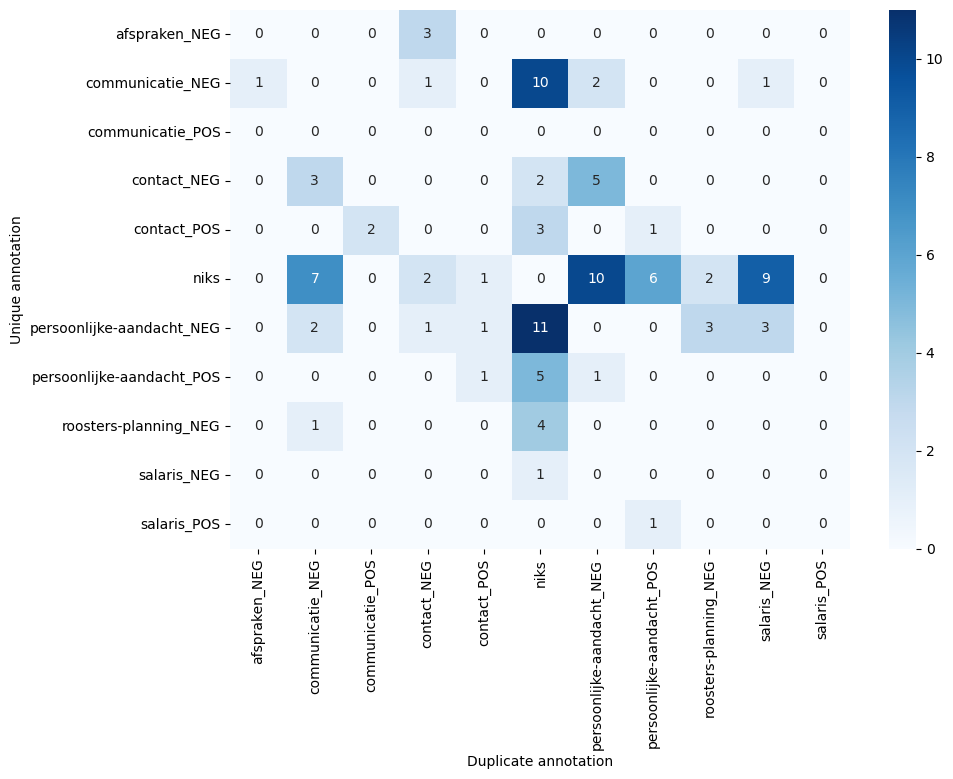

In [40]:
y_true = filtered_df['Unique_Annotation'].apply(lambda x: x[0])
y_pred = filtered_df['Duplicate_Annotation'].apply(lambda x: x[0])

# Get the unique labels
labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
#plt.title('Confusion Matrix')
plt.ylabel('Unique annotation')
plt.xlabel('Duplicate annotation')
plt.show()

### prepare final dataset for batch 3

In [41]:
# Find the common annotation for each row
df_two_same['common_annotation'] = df_two_same.apply(
    lambda row: row['batch3-m3wQfDdV4G'] if row['batch3-m3wQfDdV4G'] == row['batch3-u3cNtS9xR7'] or row['batch3-m3wQfDdV4G'] == row['batch3-health'] else row['batch3-u3cNtS9xR7'],
    axis=1
)

new_df = pd.DataFrame()
# Apply the function to the column and create new columns
new_df = df_two_same.apply(find_annotations, axis=1)
new_df['occurs_in_twice'] = new_df.apply(lambda row: any(value in row['twice'] for value in row['once']), axis=1)
print(Counter(new_df['occurs_in_twice']))

# Drop the annotator columns
df_two_same = df_two_same.drop(columns=['batch3-m3wQfDdV4G','batch3-u3cNtS9xR7','batch3-health'])

# Drop duplicate sentences and keep the common annotation
df_two_same = df_two_same.drop_duplicates(subset=['text'], keep='first')

# Drop duplicate sentences and keep the first annotator's annotation
df_all_same = df_all_same[['text', 'batch3-m3wQfDdV4G']].drop_duplicates(subset=['text'], keep='first')

# Rename the 'annotator1' column to 'common_annotation'
df_all_same = df_all_same.rename(columns={'batch3-m3wQfDdV4G': 'common_annotation'})
df_all_same = df_all_same[['text', 'common_annotation']]

Counter({False: 136, True: 64})


In [42]:
64/136

0.47058823529411764

In [43]:
#store df's per batch
df3all_same = df_all_same.copy()
df3two_same = df_two_same.copy()
df3all_different = df_all_different.copy()

#combine datasets with agreement
batch3_dataset = pd.concat([df_all_same, df_two_same])
batch3_dataset

#write dataset without agreement to .csv for re-annotation
df_all_different['common_annotation'] = ''
#df_all_different.to_csv("data/batch3_reannotation.csv", sep=";")

# Descriptive statistics annotation experiment

In [44]:
#df with all data with 100 % agreement
combined_df_all_same = pd.concat([df1all_same, df2all_same, df3all_same])

#df with all data with 2/3 agreement
combined_df_two_same = pd.concat([df1two_same, df2two_same, df3two_same])
#combined_df_two_same.head()

In [45]:
#df with all data without agreement (re-annotated)
batch1_reannotated = pd.read_excel('data/batch1_reannotation.xlsx', index_col=0)
batch2_reannotated = pd.read_excel('data/batch2_reannotation.xlsx', index_col=0)
batch3_reannotated = pd.read_excel('data/batch3_reannotation.xlsx', index_col=0)
combined_df_all_different = pd.concat([batch1_reannotated, batch2_reannotated, batch3_reannotated])


In [46]:
combined_df_all_different.shape

(206, 11)

## Determine aspects with most and least agreement

In [47]:
def remove_suffix(annotations):
    clean_annotations= []
    for annotation in ast.literal_eval(annotations):
        if annotation.endswith('_POS'):
            clean_annotations.append(annotation[:-4])
        elif annotation.endswith('_NEG'):
            clean_annotations.append(annotation[:-4])
        else:
            clean_annotations.append(annotation)
    return clean_annotations


In [48]:
# Create a new column with annotations without _POS and _NEG suffixes and sort them alphabetically
combined_df_all_different['clean_annotation'] = combined_df_all_different['common_annotation'].apply(remove_suffix).apply(lambda x: sorted(x))
combined_df_all_same['clean_annotation'] = combined_df_all_same['common_annotation'].apply(remove_suffix).apply(lambda x: sorted(x))
combined_df_two_same['clean_annotation'] = combined_df_two_same['common_annotation'].apply(remove_suffix).apply(lambda x: sorted(x))

#sort non cleaned columns
combined_df_all_different['common_annotation'] = combined_df_all_different['common_annotation'].apply(lambda x: sorted(ast.literal_eval(x)))
combined_df_all_same['common_annotation'] = combined_df_all_same['common_annotation'].apply(lambda x: sorted(ast.literal_eval(x)))
combined_df_two_same['common_annotation'] = combined_df_two_same['common_annotation'].apply(lambda x: sorted(ast.literal_eval(x)))

# Sort the Counter dictionary based on its values (in descending order)
print(f"labels with most disagreement:\n", sorted(Counter(combined_df_all_different['clean_annotation'].apply(lambda x: str(x))).items(), key=lambda x: x[1], reverse=True)[:5], '\n')
print(f"labels with least disagreement:\n", sorted(Counter(combined_df_all_same['clean_annotation'].apply(lambda x: str(x))).items(), key=lambda x: x[1], reverse=True)[:5], '\n')

labels with most disagreement:
 [("['persoonlijke-aandacht']", 26), ("['niks']", 24), ("['contact', 'persoonlijke-aandacht']", 21), ("['contact']", 20), ('[]', 19)] 

labels with least disagreement:
 [("['niks']", 229), ("['persoonlijke-aandacht']", 192), ("['salaris']", 71), ("['communicatie']", 50), ("['roosters-planning']", 42)] 



In [49]:
combined_df_all_different.head()

,text,batch1-p1dJf8bNcR,batch1-q1kEz5xVnW,batch1-s1gHt0uLrM,common_annotation,batch2-health,batch2-v2gJkDpZ5M,batch2-y2nLcHfB8X,batch3-m3wQfDdV4G,batch3-u3cNtS9xR7,batch3-health,clean_annotation
3,"1 centraal contactpersoon, zoals voorheen die ...",['contact_POS'],['niks'],['contact_NEG'],[contact_NEG],NaN,NaN,NaN,NaN,NaN,NaN,[contact]
13,Allemaal praatjes en lege woorden. Na 20 jaar...,"['afspraken_NEG', 'communicatie_NEG']",['afspraken_NEG'],['niks'],[afspraken_NEG],NaN,NaN,NaN,NaN,NaN,NaN,[afspraken]
18,Als er bv gezegd wordt dat er Vrijdag of Maand...,"['afspraken_NEG', 'persoonlijke-aandacht_POS']",['communicatie_NEG'],['afspraken_NEG'],"[afspraken_NEG, persoonlijke-aandacht_POS]",NaN,NaN,NaN,NaN,NaN,NaN,"[afspraken, persoonlijke-aandacht]"
20,Als er een roosterwijziging is dan mag WERKMAA...,"['communicatie_NEG', 'roosters-planning_NEG']",['communicatie_NEG'],['roosters-planning_NEG'],[communicatie_NEG],NaN,NaN,NaN,NaN,NaN,NaN,[communicatie]
32,Beter communiceren over de uren niet zomaar zo...,"['communicatie_NEG', 'roosters-planning_NEG']",['communicatie_NEG'],['roosters-planning_NEG'],"[communicatie_NEG, roosters-planning_NEG]",NaN,NaN,NaN,NaN,NaN,NaN,"[communicatie, roosters-planning]"


In [50]:
## Make final distribution of labels

In [51]:
final_combined_df = pd.concat([combined_df_all_same, combined_df_two_same, combined_df_all_different])

final_counts_without_sentiment = sorted(Counter(final_combined_df['clean_annotation'].apply(lambda x: str(x))).items(), key=lambda x: x[1], reverse=True)
print(f"Top 5 occurring labels in final dataset\n", final_counts_without_sentiment[:5], '\n')
pd.DataFrame(final_counts_without_sentiment).to_csv("data/dataset_distribution_withoutsentiment.csv")

final_counts = sorted(Counter(final_combined_df['common_annotation'].apply(lambda x: str(x))).items(), key=lambda x: x[1], reverse=True)
print(f"Top 5 occurring labels in final dataset\n", final_counts[:5], '\n')
pd.DataFrame(final_counts).to_csv("data/dataset_distribution.csv")

Top 5 occurring labels in final dataset
 [("['niks']", 376), ("['persoonlijke-aandacht']", 367), ("['communicatie']", 134), ("['salaris']", 112), ("['contact']", 98)] 

Top 5 occurring labels in final dataset
 [("['niks']", 376), ("['persoonlijke-aandacht_NEG']", 262), ("['communicatie_NEG']", 125), ("['salaris_NEG']", 108), ("['persoonlijke-aandacht_POS']", 105)] 



In [52]:
# Initialize two empty Counters: one for _POS and one for _NEG
pos_counter = Counter()
neg_counter = Counter()

# Count _POS and _NEG annotations
for annotations in final_combined_df['common_annotation']:
    for annotation in annotations:
        if '_POS' in annotation:
            # Remove the _POS suffix and update the counter
            label = annotation[:-4]
            pos_counter[label] += 1
        elif '_NEG' in annotation:
            # Remove the _NEG suffix and update the counter
            label = annotation[:-4]
            neg_counter[label] += 1

# Convert the Counters to DataFrames
pos_df = pd.DataFrame(pos_counter.items(), columns=['Label', 'POS_Count'])
neg_df = pd.DataFrame(neg_counter.items(), columns=['Label', 'NEG_Count'])

# Merge the DataFrames on the 'Label' column
merged_df = pos_df.merge(neg_df, on='Label', how='outer')

# Fill any missing values with 0
merged_df[['POS_Count', 'NEG_Count']] = merged_df[['POS_Count', 'NEG_Count']].fillna(0)

# Sort the DataFrame by POS_Count and/or NEG_Count as desired
merged_df = merged_df.sort_values(by=['POS_Count', 'NEG_Count'], ascending=False).reset_index(drop=True)

# Print the DataFrame
print(merged_df)

merged_df.to_csv("data/sentiment_counts.csv")

                   Label  POS_Count  NEG_Count
0  persoonlijke-aandacht        141        370
1                contact         57        155
2           communicatie         33        212
3                salaris         23        153
4              afspraken          8         67
5      roosters-planning          5        134


In [53]:
final_combined_df.reset_index(drop=True).to_csv("data/final_dataset_ABSA.csv", sep=';')

In [54]:
df = pd.DataFrame(["['contact', 'salaris']", "['contact']", "['salaris']"]).T 
df2 = pd.DataFrame(["['contact', 'salaris']", "['contact', 'salaris']", "['salaris']"]).T 
df3 = pd.DataFrame(["['contact', 'salaris']", "['persoonlijke aandacht']", "['afspraken']"]).T 

In [55]:
df

,0,1,2
0,"['contact', 'salaris']",['contact'],['salaris']


In [56]:
df2

,0,1,2
0,"['contact', 'salaris']","['contact', 'salaris']",['salaris']


In [57]:
df3

,0,1,2
0,"['contact', 'salaris']",['persoonlijke aandacht'],['afspraken']


In [58]:
kappam_fleiss(df,  detail=True)

            Fleiss` Kappa for m Raters            
Subjects = 1
  Raters = 3
   Kappa = -0.500

       z = -1.225
 p-value = 0.221

                        Kappa      z  p.value
['contact', 'salaris']   -0.5 -0.866    0.386
['contact']              -0.5 -0.866    0.386
['salaris']              -0.5 -0.866    0.386

In [59]:
kappam_fleiss(df2,  detail=True)

            Fleiss` Kappa for m Raters            
Subjects = 1
  Raters = 3
   Kappa = -0.500

       z = -0.866
 p-value = 0.386

                        Kappa      z  p.value
['contact', 'salaris']   -0.5 -0.866    0.386
['salaris']              -0.5 -0.866    0.386

In [60]:
kappam_fleiss(df3,  detail=True)

            Fleiss` Kappa for m Raters            
Subjects = 1
  Raters = 3
   Kappa = -0.500

       z = -1.225
 p-value = 0.221

                           Kappa      z  p.value
['afspraken']               -0.5 -0.866    0.386
['contact', 'salaris']      -0.5 -0.866    0.386
['persoonlijke aandacht']   -0.5 -0.866    0.386